# Jet Compression using an Autoencoder

In [6]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

## Loading and preparing the data

In [7]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [9]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [10]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [11]:
def mse_loss(input, target, size_average=None, reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[bool], Optional[bool], str) -> Tensor
    r"""mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor

    Measures the element-wise mean squared error.

    See :class:`~torch.nn.MSELoss` for details.
    """
    if not (target.size() == input.size()):
        warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                      "This will likely lead to incorrect results due to broadcasting. "
                      "Please ensure they have the same size.".format(target.size(), input.size()),
                      stacklevel=2)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)

    ret = (input - target) ** 2
    factor = torch.full(ret.size(), 1)
    factor[:, 2] = 2.4
    ret = ret * factor
    if reduction != 'none':
        ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)

    return ret

In [12]:
bs = 64  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()
loss_func = mse_loss

In [15]:
class AE_2D(nn.Module):
    def __init__(self, n_features=4):
        super(AE_2D, self).__init__()
        self.en1 = nn.Linear(n_features, 20)
        self.en2 = nn.Linear(20, 10)
        self.en3 = nn.Linear(10, 6)
        self.en4 = nn.Linear(6, 2)
        self.de1 = nn.Linear(2, 6)
        self.de2 = nn.Linear(6, 10)
        self.de3 = nn.Linear(10, 20)
        self.de4 = nn.Linear(20, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)


class AE_big_2D_v1(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v1, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 2)
        self.de1 = nn.Linear(2, 4)
        self.de2 = nn.Linear(4, 6)
        self.de3 = nn.Linear(6, 8)
        self.de4 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    

class AE_big_2D_v2(nn.Module):
    def __init__(self, n_features=4):
        super(AE_big_2D_v2, self).__init__()
        self.en1 = nn.Linear(n_features, 8)
        self.en2 = nn.Linear(8, 6)
        self.en3 = nn.Linear(6, 4)
        self.en4 = nn.Linear(4, 3)
        self.en5 = nn.Linear(3, 2)
        self.de1 = nn.Linear(2, 3)
        self.de2 = nn.Linear(3, 4)
        self.de3 = nn.Linear(4, 6)
        self.de4 = nn.Linear(6, 8)
        self.de5 = nn.Linear(8, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en5(self.tanh(self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))))

    def decode(self, x):
        return self.de5(self.tanh(self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [16]:
n_features = len(train.loc[0])
model = AE_2D(n_features=n_features)

In [17]:
# Training
#epochs_list = [7, 5, 3, 2, 2]
epochs_list = [40, 40, 20, 20, 20]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii])
    #opt = optim.SGD(model.parameters(), lr=lrs[ii], momentum=0.9, nesterov=True)
    #opt = optim.RMSprop(model.parameters(), lr=lrs[ii], momentum=0.9)
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch 0: Validation loss = 0.16334022527930875
Epoch 1: Validation loss = 0.13559005072694852
Epoch 2: Validation loss = 0.1259915041329785
Epoch 3: Validation loss = 0.11362314103522847
Epoch 4: Validation loss = 0.1312142463838381
Epoch 5: Validation loss = 0.10492889214156349
Epoch 6: Validation loss = 0.09467381372416189
Epoch 7: Validation loss = 0.0953531745448027
Epoch 8: Validation loss = 0.09758728749910103
Epoch 9: Validation loss = 0.08792771307155946
Epoch 10: Validation loss = 0.08398448848290319
Epoch 11: Validation loss = 0.08032143346884364
Epoch 12: Validation loss = 0.091481468018618
Epoch 13: Validation loss = 0.07594470483232632
Epoch 14: Validation loss = 0.11773251002943057
Epoch 15: Validation loss = 0.08193804613852602
Epoch 16: Validation loss = 0.08297944133781517
Epoch 17: Validation loss = 0.07936930942746656
Epoch 18: Validation loss = 0.07571263531101752
Epoch 19: Validation loss = 0.08174798875838715
Epoch 20: Validation l

KeyboardInterrupt: 

In [19]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_2D_loss00615.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [20]:
model.eval()

AE_2D(
  (en1): Linear(in_features=4, out_features=20, bias=True)
  (en2): Linear(in_features=20, out_features=10, bias=True)
  (en3): Linear(in_features=10, out_features=6, bias=True)
  (en4): Linear(in_features=6, out_features=2, bias=True)
  (de1): Linear(in_features=2, out_features=6, bias=True)
  (de2): Linear(in_features=6, out_features=10, bias=True)
  (de3): Linear(in_features=10, out_features=20, bias=True)
  (de4): Linear(in_features=20, out_features=4, bias=True)
  (tanh): Tanh()
)

In [21]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.5040, -0.9034,  1.6924,  0.5473], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([-0.0017,  0.4391, -0.0348, -0.5163], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3309,  0.4142,  1.3175, -0.6282], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.4994,  0.2596,  1.1001, -0.6954], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.5478, -0.2960,  1.1852, -0.6810], grad_fn=<AddBackward0>)
 


In [22]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [408.7311     -1.4626178   3.0915318 907.9413   ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.2614264e+02  6.7856067e-01 -5.4463994e-02  3.0309042e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [186.21648      0.63893807   2.408617   239.40747   ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [165.78368      0.39228833   2.012602   201.23514   ]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [159.9159      -0.49376535   2.1677046  209.3949    ]
 


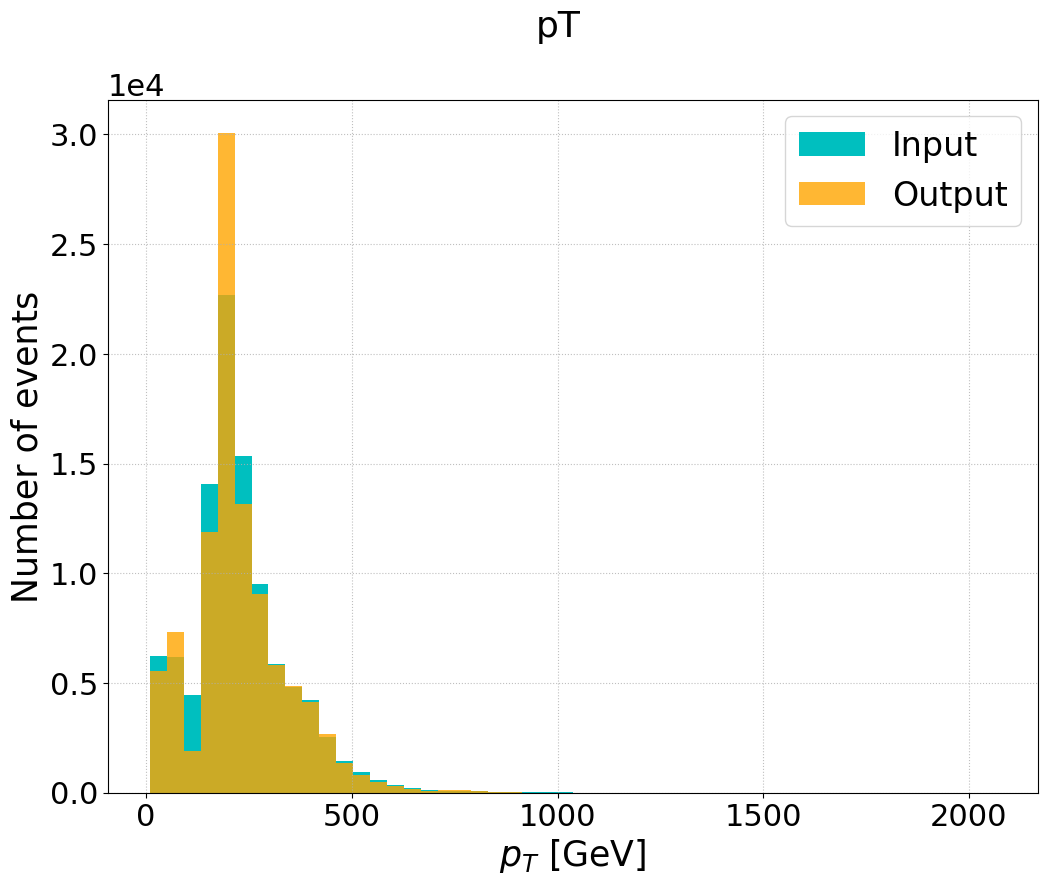

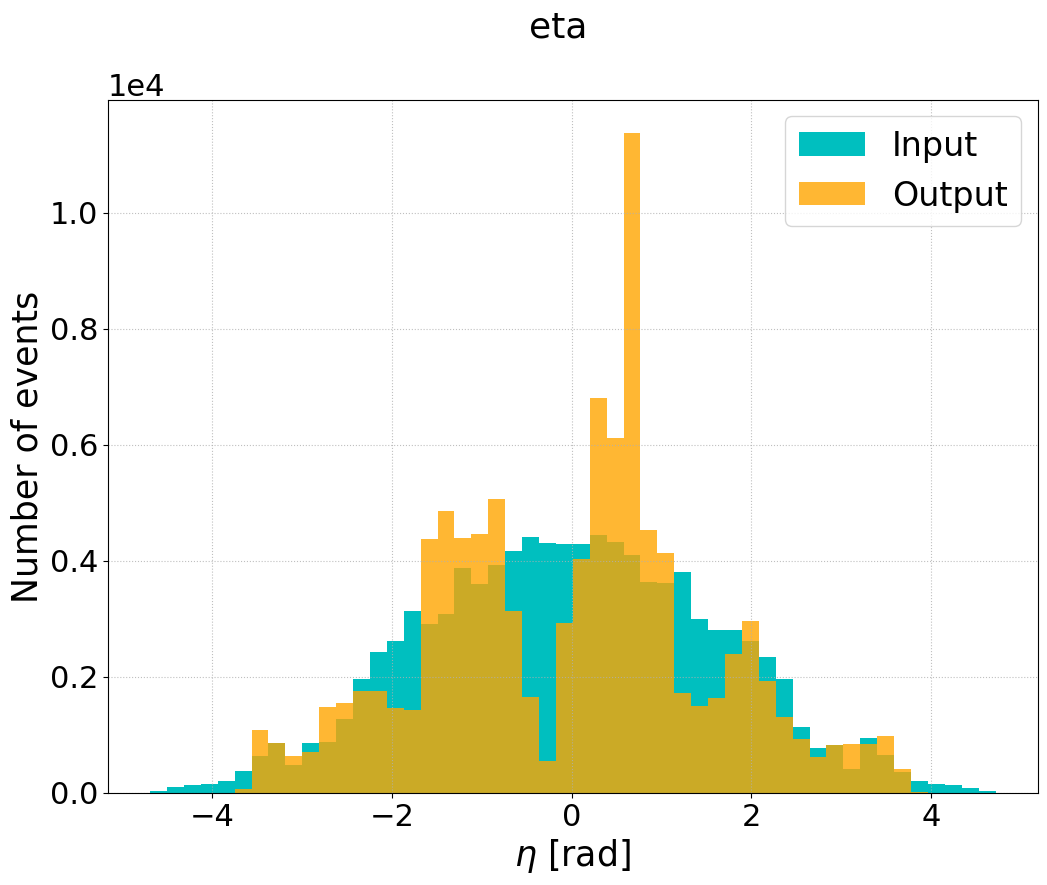

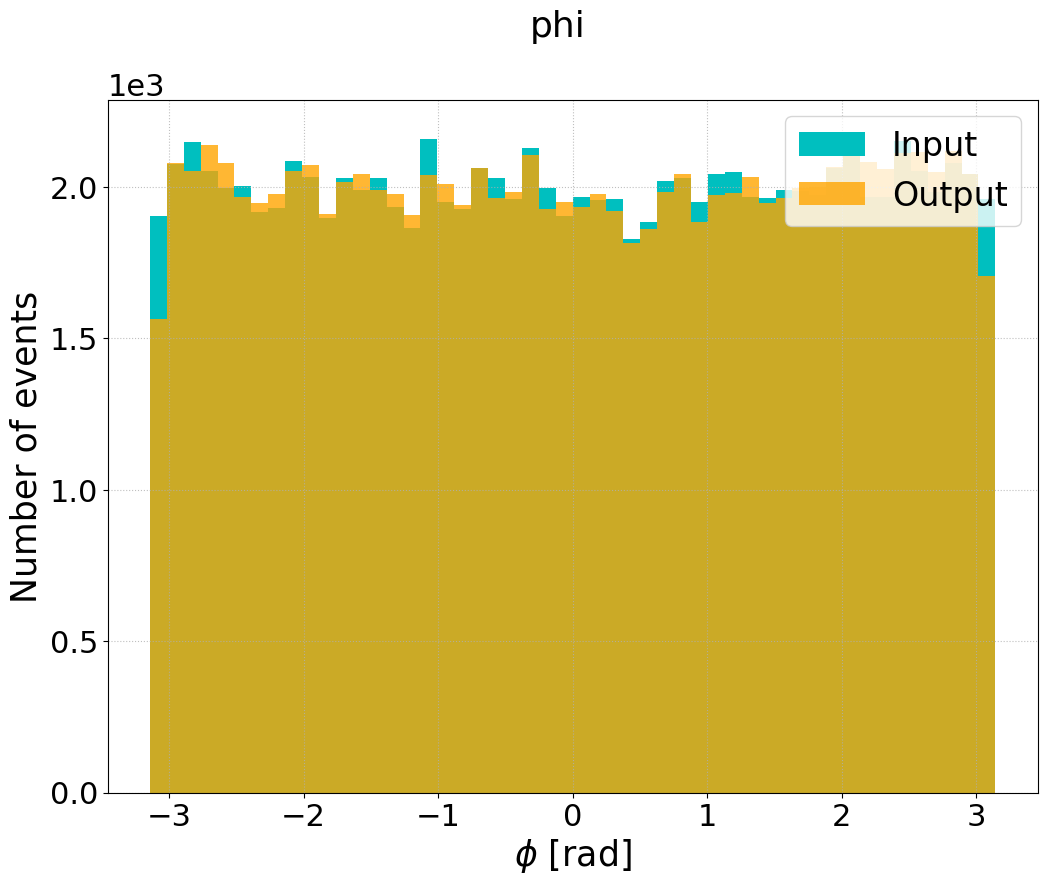

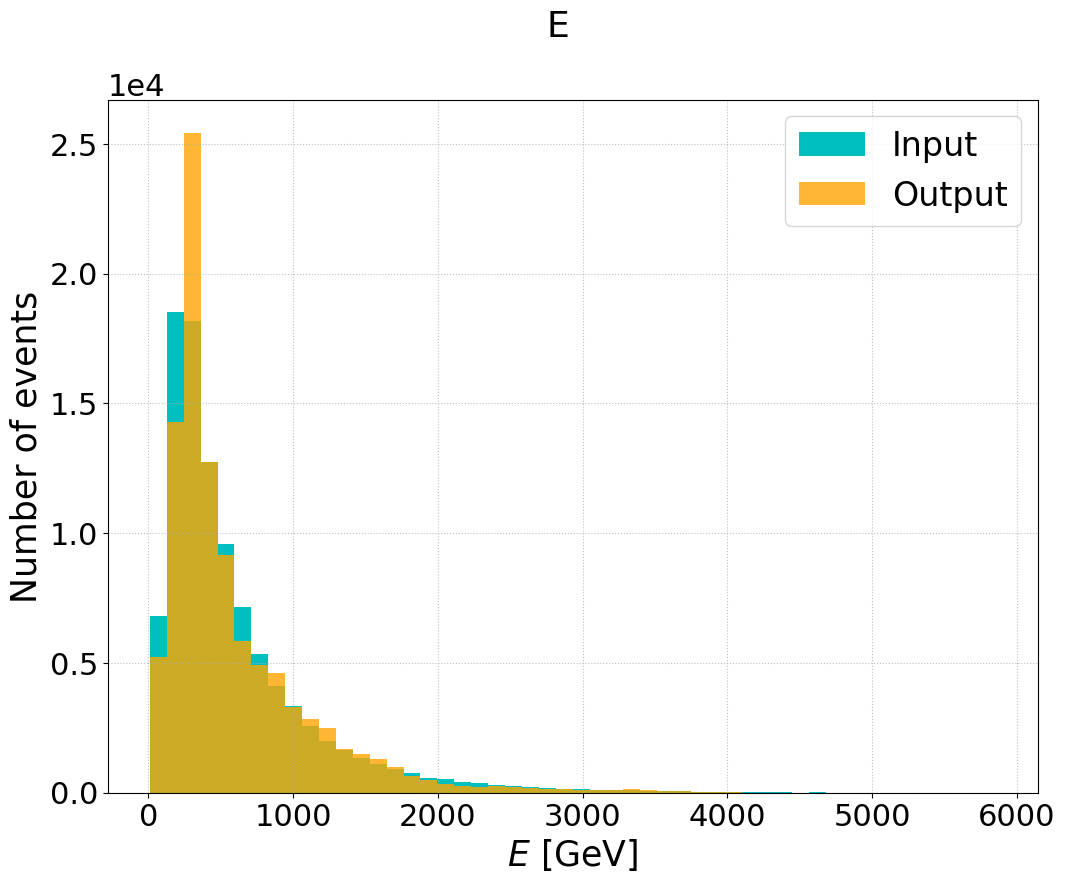

In [23]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    plt.legend()
    ms.sciy()

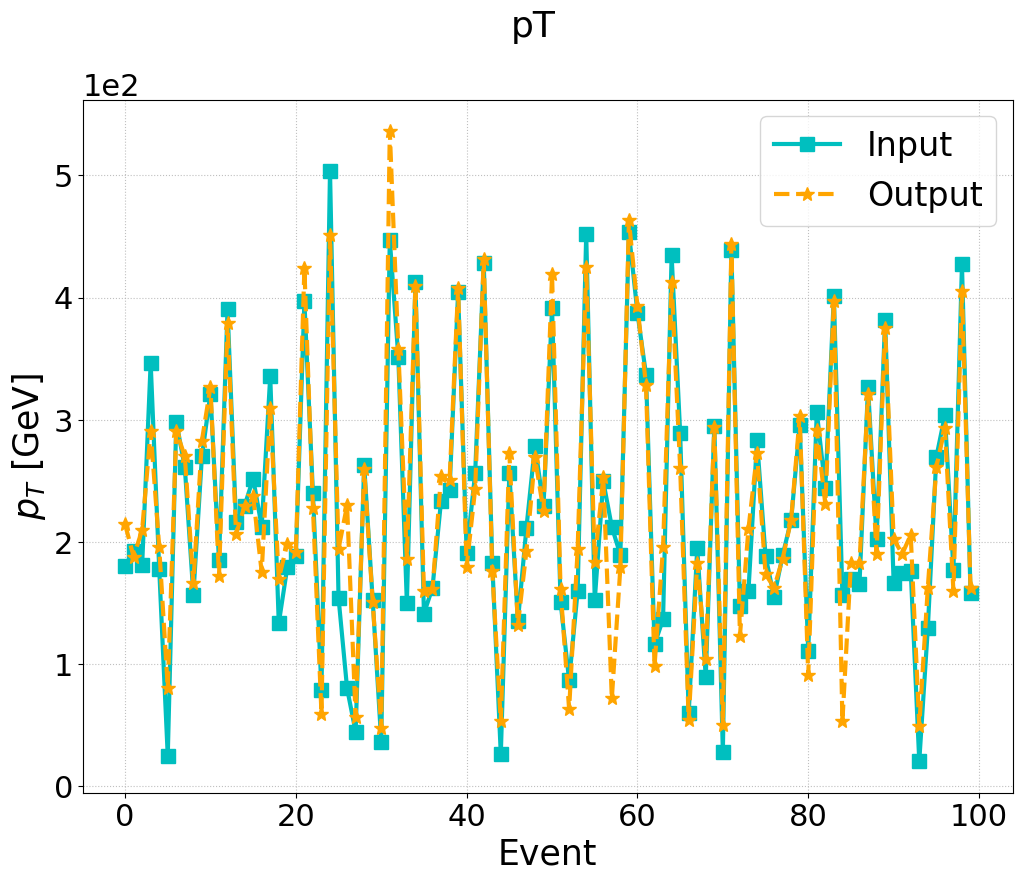

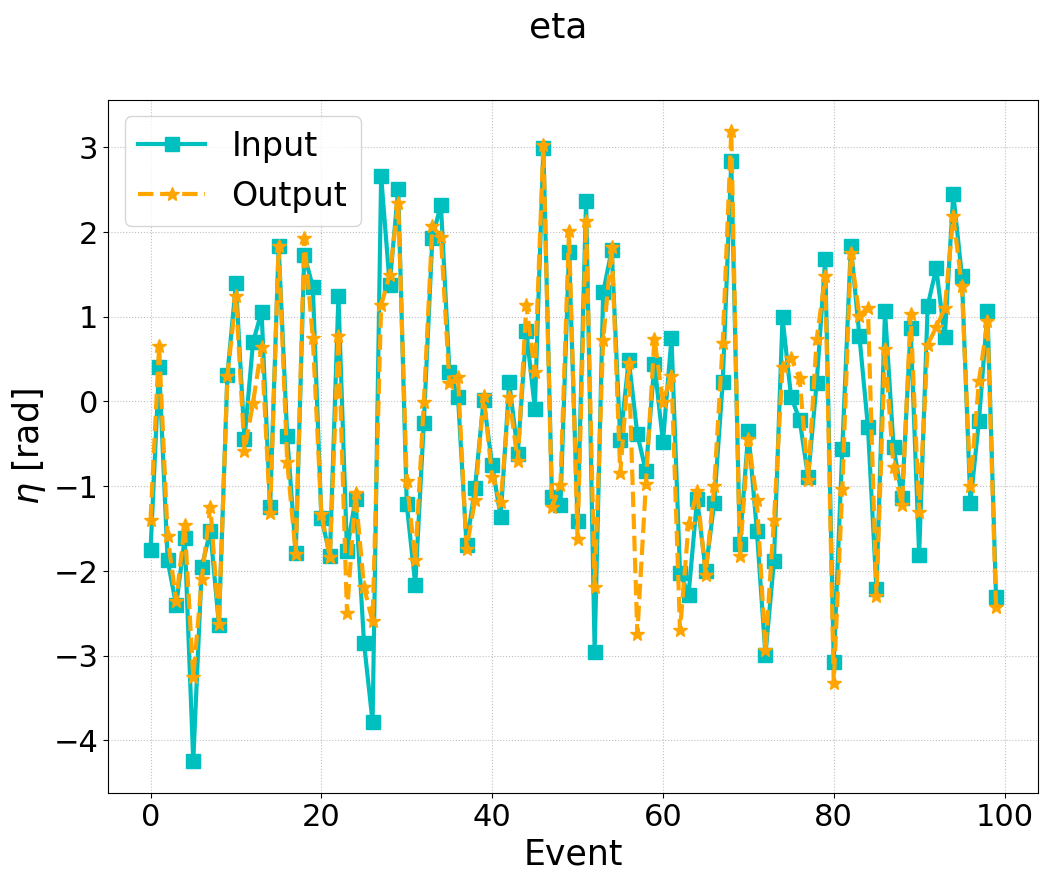

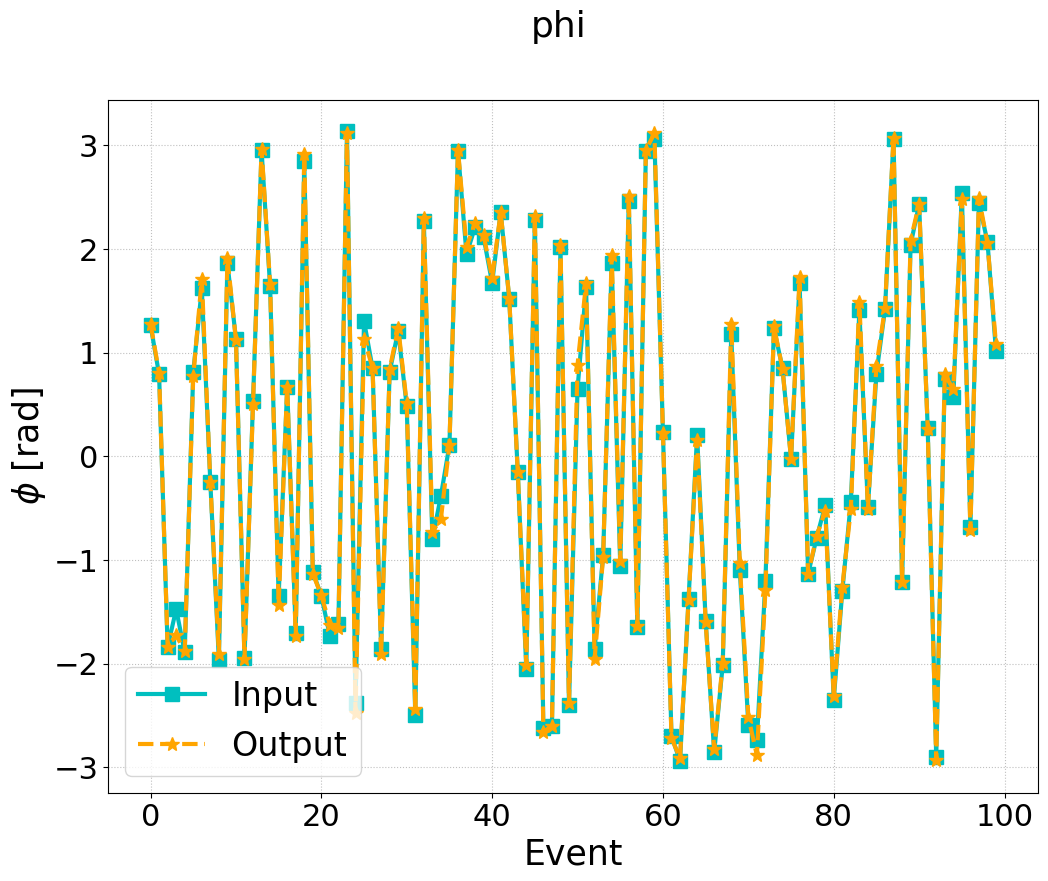

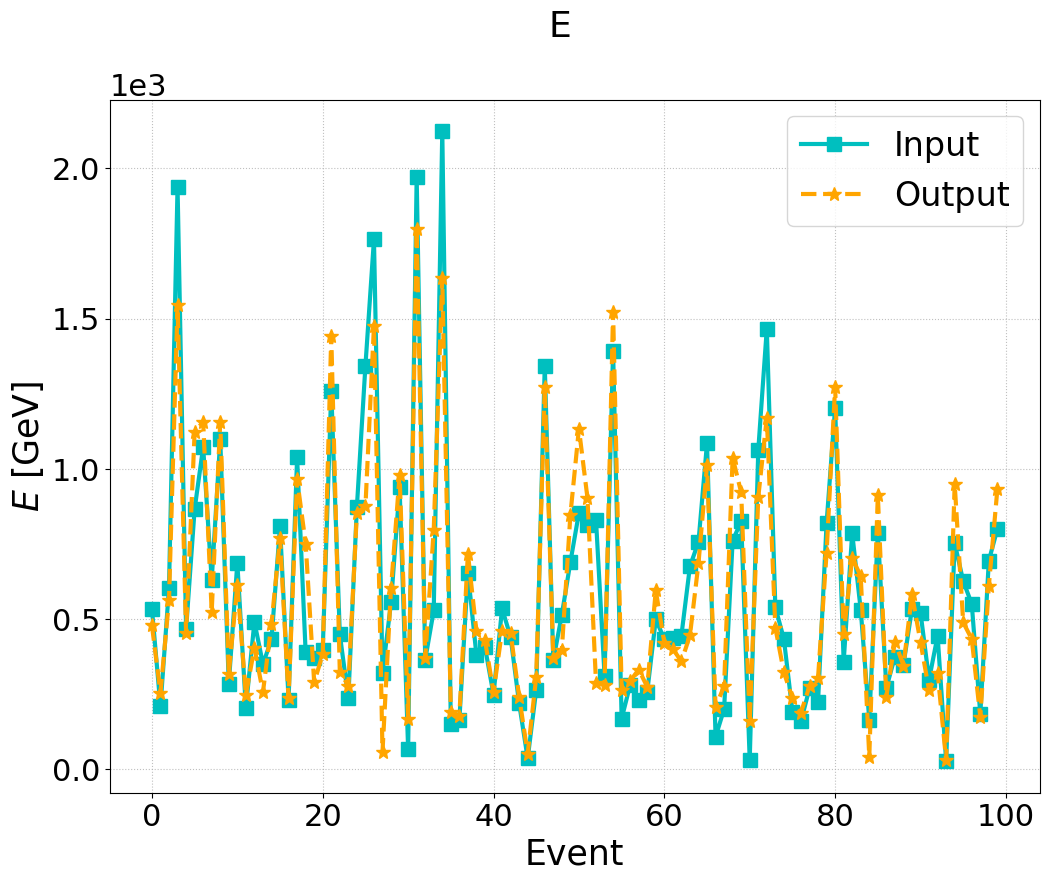

In [24]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()